<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_08_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **=== 0. 簡介 ===**
1. Set up
2. Raw data & Dataset & Dataloader
4. Replicating vit paper
    1. Equation_1: patch embedding
    2. Equation_2: multi-head attention
    3. Equation_3: multi-layer perceptron
    4. Equation_4
5. Train
6. Transfor for vit
7. Make prediction

# **=== 1. Set up ===**

In [ ]:
!pip install torchinfo

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

import matplotlib.pyplot as plt

# **=== 2. Raw data, dataset, dataloader ===**

## 2.1 Raw data

In [ ]:
import os
import zipfile
import requests
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "db_image_data"

if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists.")
else:
    print(f"[INFO] {image_path} not exists, creating ...")
    image_path.mkdir(parents = True, exist_ok = True)

    with open(data_path / "db_image_data.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"[INFO] zip file downloading ...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "db_image_data.zip", "r") as zip_f:
        print(f"[INFO] zip file unziping ...")
        zip_f.extractall(image_path)

    zip_file_path = data_path / "db_image_data.zip"
    if zip_file_path.exists():
        print(f"[INFO] zip file removing ...")
        os.remove(zip_file_path)

[INFO] data/db_image_data not exists, creating ...
[INFO] zip file downloading ...
[INFO] zip file unziping ...
[INFO] zip file removing ...


## 2.2 Transforms
ViT transforms image into 224*224

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

## 2.3 Dataset

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dataset = datasets.ImageFolder(root = train_dir, transform = transform)
test_dataset = datasets.ImageFolder(root = test_dir, transform = transform)

## 2.4 Dataloader

In [ ]:
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True, drop_last = True)

test_dataloader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False, drop_last = True)

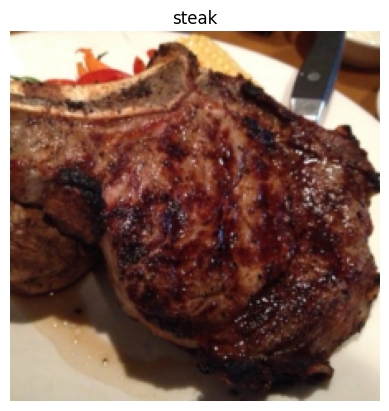

In [ ]:
# Check dataloader
images, labels = next(iter(train_dataloader))
image = images[0]
label = labels[0]

class_names = ['pizza', 'steak', 'sushi']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off");

# **=== 3. Replicating ViT paper ===**
1. Path embedding : ```x_input = [class_token, image_path1, image_path2, image_path3 ...]``` each patch is learnable
2. Multi-head-attention : MSA wrapping LayerNorm layer(LN) -> (residual connection) :   
    ``` X_output_MSA_block =  MSA_layer((LN_layer(x_input))) + x_output ```
3. Multilayer-perceptron layer : MLP wrapping LayerNorm(LN) -< (residual connection) :   
    ``` x_output_MLP_block = MLP_layer(LN_layer(X_output_MSA_block)) + x_output ```
4. Output layer (y) :   
    ``` y = Linear_layer(LN_layer(x_output_MLP_block[0]))```

## 3.1 圖示

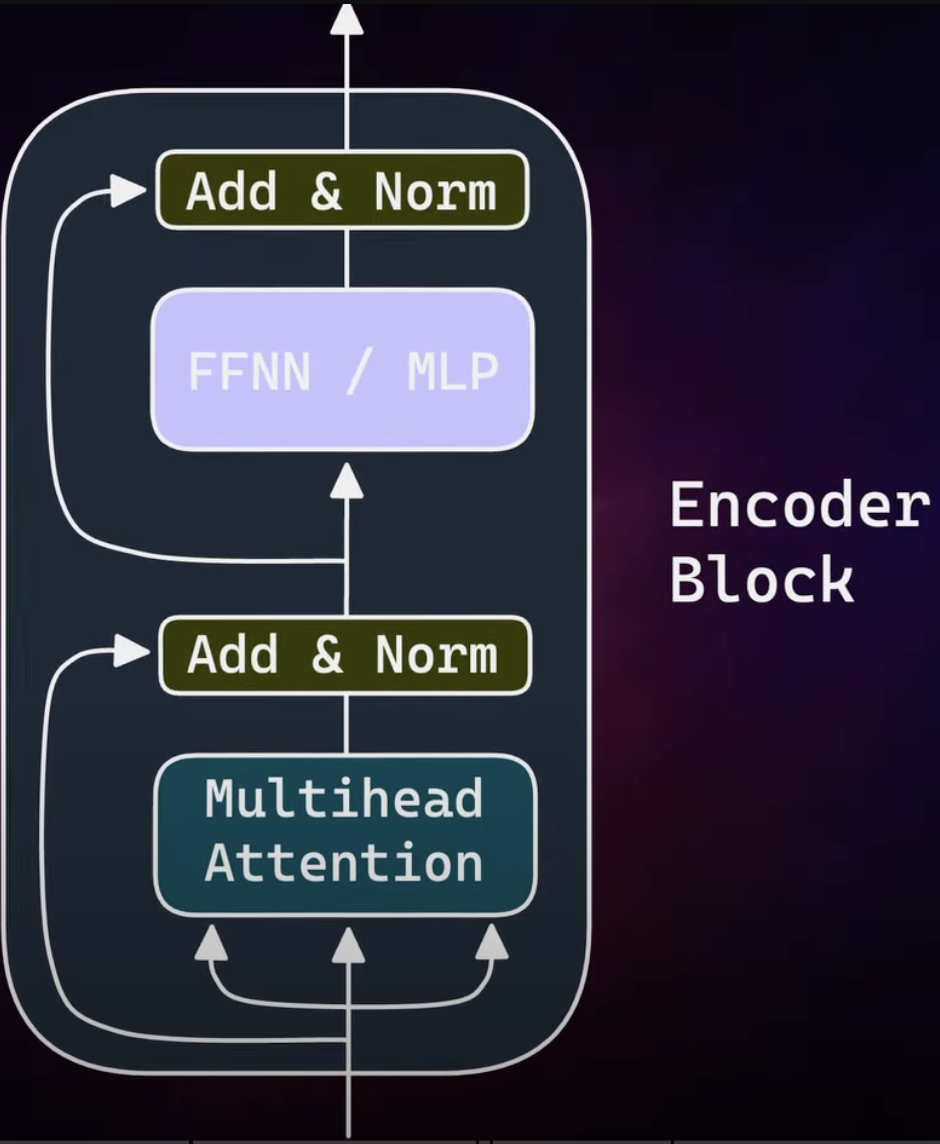

## 3.2 test